In [1]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
import tensorflow as tf
tf_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

In [3]:
from quantile_transformer_tf import QuantileTransformerTF

In [4]:
import utils_rich_mrartemev
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.externals import joblib

In [5]:
utils_rich = utils_rich_mrartemev
particles = ['kaon', 'pion', 'proton', 'muon']

In [6]:
data_full = {
    particle : utils_rich.load_and_merge_and_cut(utils_rich.datasets[particle])
    for particle in particles
}

In [7]:
models_path = "/home/martemev/data/Lambda/RICH-GAN/research/exported_model/"
preprocessors_path = "/home/martemev/data/Lambda/RICH-GAN/research/preprocessors/"

export_models_path = "exported_model_tfScaler_attached/"

model_name_format = "FastFastRICH_Cramer_{}"
preprocessor_name_format = "FastFastRICH_Cramer_{}_preprocessor.pkl"

In [8]:
def tf_scalers_from_scaler(scaler, dtype=np.float64):
    scaler_x_tf = QuantileTransformerTF(scaler,
                                        list(range(utils_rich.y_count, scaler.quantiles_.shape[1])),
                                        dtype)
    scaler_y_tf = QuantileTransformerTF(scaler,
                                        list(range(0, utils_rich.y_count)),
                                        dtype)
    return scaler_x_tf, scaler_y_tf

In [9]:
for particle in particles:
    predictor = tf.contrib.predictor.from_saved_model(
                    os.path.join(models_path, model_name_format.format(particle))
                )
    scaler = joblib.load(
        os.path.join(preprocessors_path, preprocessor_name_format.format(particle))
    )
    
    input_name, = [x.name for x in predictor.feed_tensors['x'].consumers()[0].outputs]
    output_name = predictor.fetch_tensors['dlls'].name
    
    mod_graph = tf.Graph()
    with mod_graph.as_default():
        tf_scaler_x, tf_scaler_y = tf_scalers_from_scaler(scaler)
        
        input_tensor = tf.placeholder(dtype=tf.float64, shape=(None, len(utils_rich.raw_feature_columns)), name='x')
        scaled_input = tf.cast(tf_scaler_x.transform(input_tensor, False), dtype=tf.float32)
        
        with tf.Session(config=tf_config) as sess:
            meta_graph_def = tf.saved_model.loader.load(
                sess, ['serve'],
                os.path.join(models_path, model_name_format.format(particle)),
                input_map={input_name : scaled_input}
            )
            scaled_output = mod_graph.get_tensor_by_name(output_name)
            output_tensor = tf_scaler_y.transform(tf.cast(scaled_output, dtype=tf.float64), True)

            sub_graph_def = tf.graph_util.convert_variables_to_constants(
                sess, sess.graph_def, [output_tensor.op.name]
            )
    
    reduced_graph = tf.Graph()
    with reduced_graph.as_default():
        with tf.Session(config=tf_config) as sess:
            tf.import_graph_def(sub_graph_def, name='')
            input_tensor  = reduced_graph.get_tensor_by_name(input_tensor.name)
            output_tensor = reduced_graph.get_tensor_by_name(output_tensor.name)

            predictions = sess.run(
                output_tensor,
                feed_dict={
                    input_tensor : data_full[particle][utils_rich.raw_feature_columns].values
                }
            )
            
            for i, col in enumerate(utils_rich.dll_columns):
                data_full[particle]["predicted_{}".format(col)] = predictions[:,i]

            model_export_dir = os.path.join(export_models_path, model_name_format.format(particle) + "_tfScaler")
            tf.saved_model.simple_save(
                sess, model_export_dir,
                inputs={"x": input_tensor},
                outputs={"dlls": output_tensor}
            )

INFO:tensorflow:Restoring parameters from /home/martemev/data/Lambda/RICH-GAN/research/exported_model/FastFastRICH_Cramer_kaon/variables/variables


/mnt/amaevskiy/conda_env/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


INFO:tensorflow:Restoring parameters from /home/martemev/data/Lambda/RICH-GAN/research/exported_model/FastFastRICH_Cramer_kaon/variables/variables
INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: exported_model_tfScaler_attached/FastFastRICH_Cramer_kaon_tfScaler/saved_model.pb


In [10]:
from make_prediction import DataSplits

splits = {
    particle : DataSplits(*utils_rich.split(data_full[particle]))
    for particle in particles
}

pd.to_pickle(splits, 'predictions_with_tfScaler.pkl')

In [11]:
splits_ref = pd.read_pickle("predictions.pkl")

/mnt/amaevskiy/conda_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/mnt/amaevskiy/conda_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/mnt/amaevskiy/conda_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


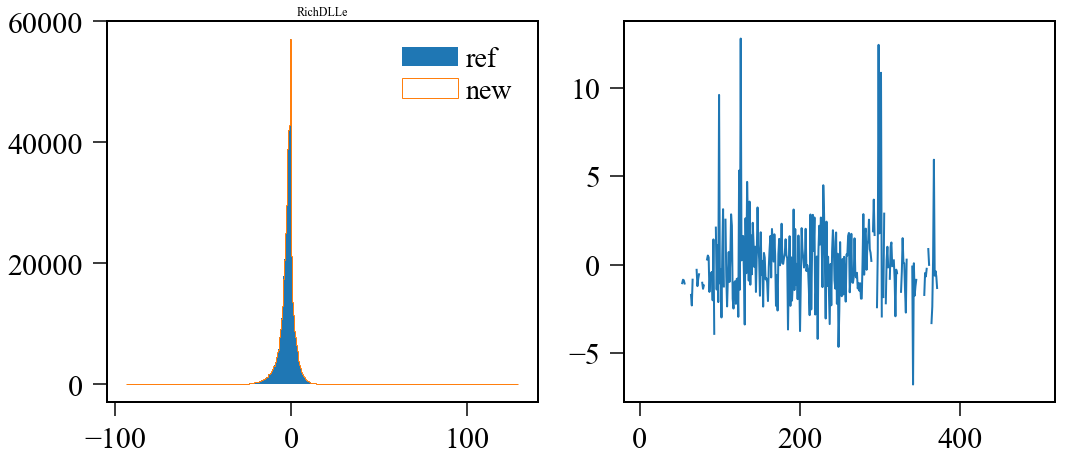

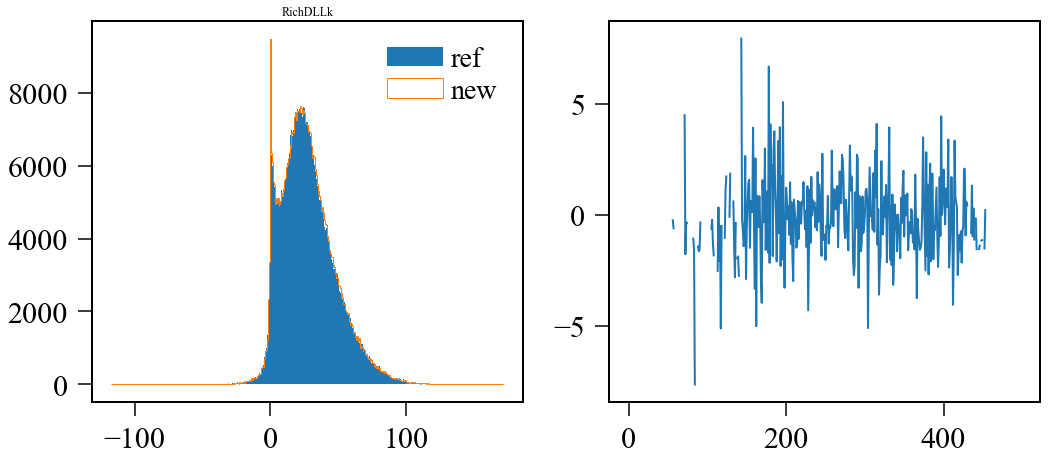

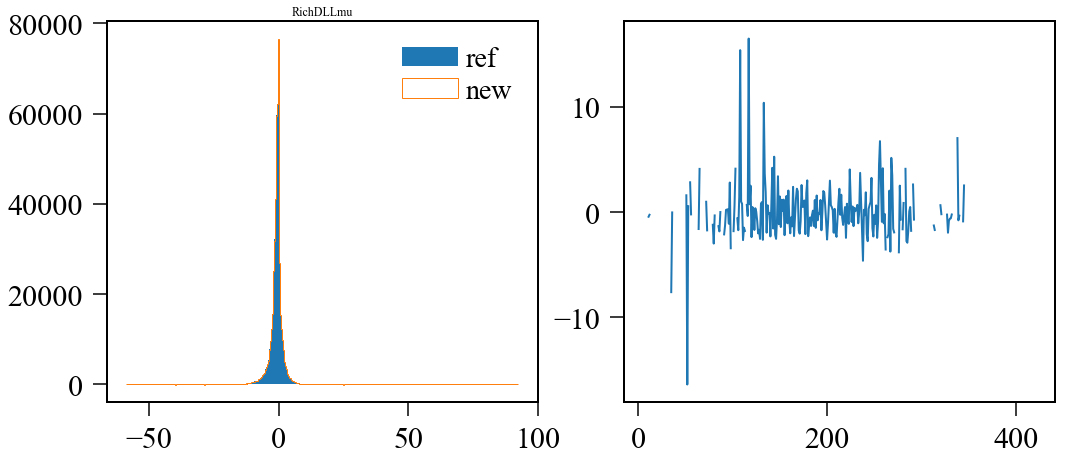

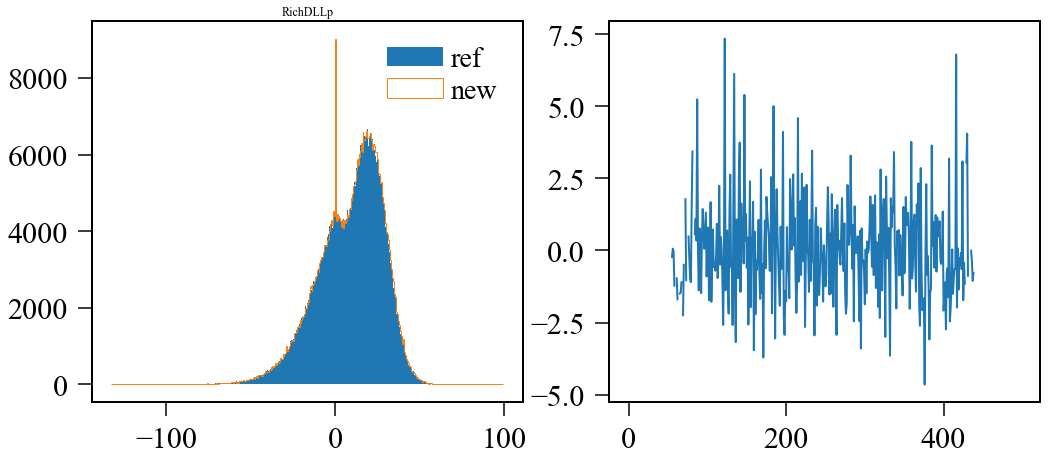

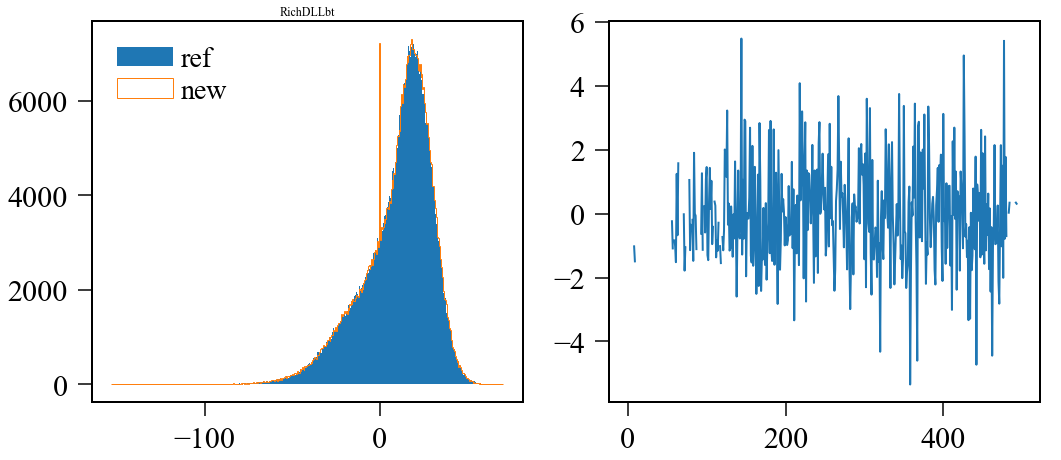

In [12]:
df = splits['kaon'].test
df_ref = splits_ref['kaon'].test

def get_range(*arrays):
    left  = min(arr.min() for arr in arrays)
    right = max(arr.max() for arr in arrays)
    return left, right

for col in utils_rich.dll_columns:
    plt.figure(figsize=(17, 7))
    plt.subplot(1, 2, 1)
    col_predicted = "predicted_{}".format(col)
    bins = np.linspace(*get_range(df_ref[col_predicted], df[col_predicted]), 500)
    h1, _, _, = plt.hist(df_ref[col_predicted], bins=bins, weights=df_ref[utils_rich.weight_col], label='ref')
    h2, _, _, = plt.hist(df    [col_predicted], bins=bins, weights=df    [utils_rich.weight_col], label='new', histtype='step')
    plt.legend()
    plt.title(col)
    
    plt.subplot(1, 2, 2)
    
    plt.plot((h2 - h1) / np.sqrt(h1))
    
    plt.show()